In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
from sklearn.utils import class_weight

# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('MPS'):
    print("MPS is available and will be used for acceleration.")

batch_size = 128
img_height = 128
img_width = 128
data_dir = 'multi_cancer'

# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode='grayscale'
)

# Grab class names from dataset
class_names = train_ds.class_names
print("Class names:", class_names)

# --- NEW: Calculate Class Weights ---
print("Calculating class weights...")
all_labels = []
class_counts = {}
# Iterate through the original directory to get total counts (approximation for training set)
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        all_labels.extend([class_names.index(class_name)] * count)

print("Class counts (total):", class_counts)

class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights_vals))
print("Class weights:", class_weights)
# ------------------------------------

Num GPUs Available:  0
Found 101517 files belonging to 16 classes.
Using 81214 files for training.
Found 101517 files belonging to 16 classes.
Using 20303 files for validation.
Class names: ['brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt', 'lung_scc']
Calculating class weights...
Class counts (total): {'brain_glioma': 5000, 'brain_menin': 5000, 'brain_tumor': 5000, 'breast_benign': 5000, 'breast_malignant': 5000, 'cervix_dyk': 5000, 'cervix_koc': 5000, 'cervix_mep': 5000, 'cervix_pab': 5000, 'colon_aca': 5000, 'colon_bnt': 5000, 'kidney_normal': 9235, 'kidney_tumor': 7284, 'lung_aca': 10000, 'lung_bnt': 10000, 'lung_scc': 10000}
Class weights: {0: np.float64(1.2689875), 1: np.float64(1.2689875), 2: np.float64(1.2689875), 3: np.float64(1.2689875), 4: np.float64(1.2689875), 5: np.float64(1.2689875), 6: np.float64(1.26

In [19]:
from tensorflow.keras.applications import ResNet50

In [20]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

def preprocess_train(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    x = data_augmentation(image)
    x = preprocess_input(x)
    return x, label

def preprocess_val(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    x = preprocess_input(image)
    return x, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

# Base model
base_model = ResNet50(
    input_shape=(128, 128, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [21]:
inputs = keras.Input(shape=(128,128,3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dropout(0.45)(x)
outputs = keras.layers.Dense(16, activation='softmax', kernel_regularizer=keras.regularizers.l2(1e-4))(x)

model = keras.Model(inputs, outputs)

loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
optimizer = keras.optimizers.Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# epochs = 10 
# print("Starting training with class weights...")
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     callbacks=[early_stop],
#     class_weight=class_weights 
# )

# model.save('cancer_model_weighted.keras')
# print("Model saved to cancer_model_weighted.keras")


In [22]:
class_weights[1] = 2.5
class_weights[9] = 2.5
class_weights[14] = 1.5
class_weights[17] = 1.5
class_weights[3] = 1.5
class_weights[4] = 1.5

In [23]:
# MAKE SURE TO TRAIN AGAIN!

In [24]:
epochs = 5
print("Starting training with class weights...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights 
)

Starting training with class weights...
Epoch 1/5


2026-01-22 22:57:55.562745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:69: Filling up shuffle buffer (this may take a while): 500 of 1000
2026-01-22 22:57:58.237796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


635/635 ━━━━━━━━━━━━━━━━━━━━ 468s 712ms/step - accuracy: 0.7654 - loss: 1.5047 - val_accuracy: 0.9168 - val_loss: 0.8446
Epoch 2/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 480s 755ms/step - accuracy: 0.9366 - loss: 1.0212 - val_accuracy: 0.9349 - val_loss: 0.8019
Epoch 3/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 481s 757ms/step - accuracy: 0.9759 - loss: 0.9115 - val_accuracy: 0.9513 - val_loss: 0.7454
Epoch 4/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 436s 686ms/step - accuracy: 0.9914 - loss: 0.8573 - val_accuracy: 0.9549 - val_loss: 0.7350
Epoch 5/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 418s 658ms/step - accuracy: 0.9966 - loss: 0.8301 - val_accuracy: 0.9520 - val_loss: 0.7488


In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(val_ds)  # shape: (num_samples, num_classes)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Concatenate all labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Convert one-hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)

report = classification_report(y_true_classes, y_pred_classes)
print(report)

159/159 ━━━━━━━━━━━━━━━━━━━━ 54s 334ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1029
           1       0.98      0.82      0.89      1017
           2       0.86      0.99      0.92      1006
           3       0.84      0.99      0.91       996
           4       0.99      0.85      0.91      1007
           5       0.99      0.85      0.91       981
           6       0.82      1.00      0.90       955
           7       0.96      0.94      0.95      1004
           8       1.00      0.96      0.98      1005
           9       0.99      0.99      0.99      1008
          10       1.00      0.99      1.00      1056
          11       0.97      0.98      0.97      1884
          12       0.97      0.96      0.97      1467
          13       0.97      0.95      0.96      2072
          14       1.00      0.98      0.99      1950
          15       0.96      0.98      0.97      1866

    accuracy                        

2026-01-22 23:37:06.873410: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


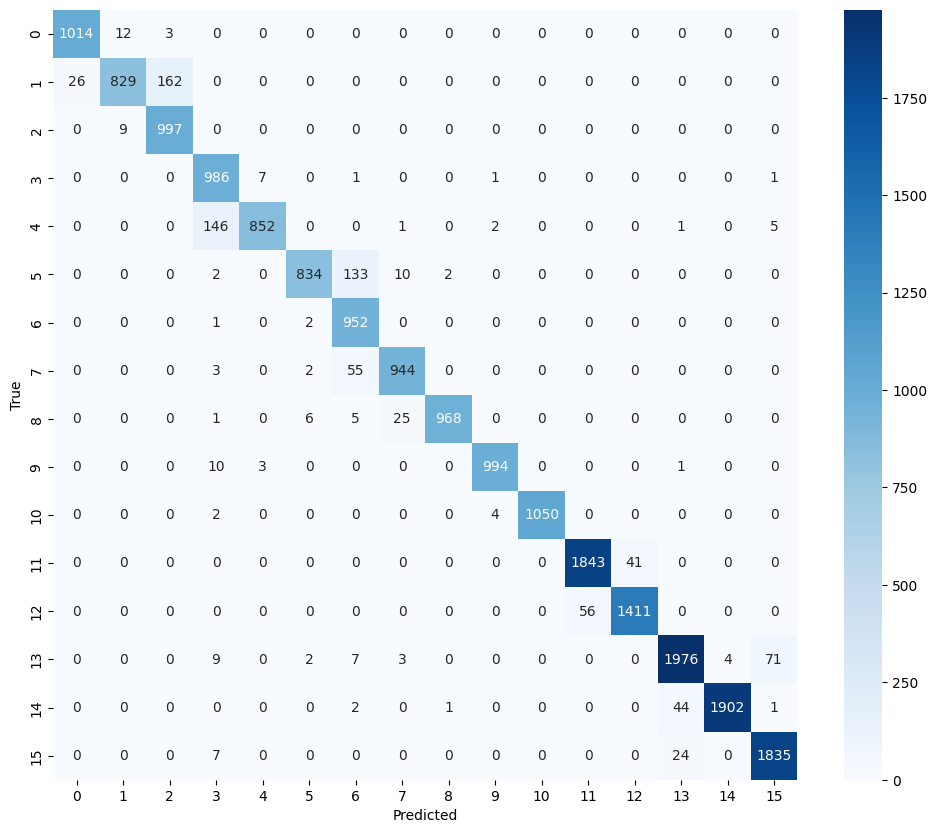

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
class_names

['brain_glioma',
 'brain_menin',
 'brain_tumor',
 'breast_benign',
 'breast_malignant',
 'cervix_dyk',
 'cervix_koc',
 'cervix_mep',
 'cervix_pab',
 'colon_aca',
 'colon_bnt',
 'kidney_normal',
 'kidney_tumor',
 'lung_aca',
 'lung_bnt',
 'lung_scc']

In [28]:
model.save("cancer_model.keras")